In [159]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
# Import module for k-means
from sklearn.cluster import KMeans, DBSCAN
#import module k-prototype
from kmodes.kprototypes import KPrototypes
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
# Format scientific notation from Pandas
pd.set_option('display.max_columns', None)

#Pour l'Ari
from sklearn.metrics.cluster import adjusted_rand_score

# prepocessing sklearn
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

#Pour la localisation du coude
from kneed import KneeLocator, DataGenerator as dg

In [190]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,order_purchase_timestamp,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,2018-05-10,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,2018-05-07,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,2017-03-10,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,2017-10-12,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,2017-11-14,289
...,...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,2017-06-08,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,2017-12-10,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,2017-02-07,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,2018-05-02,120


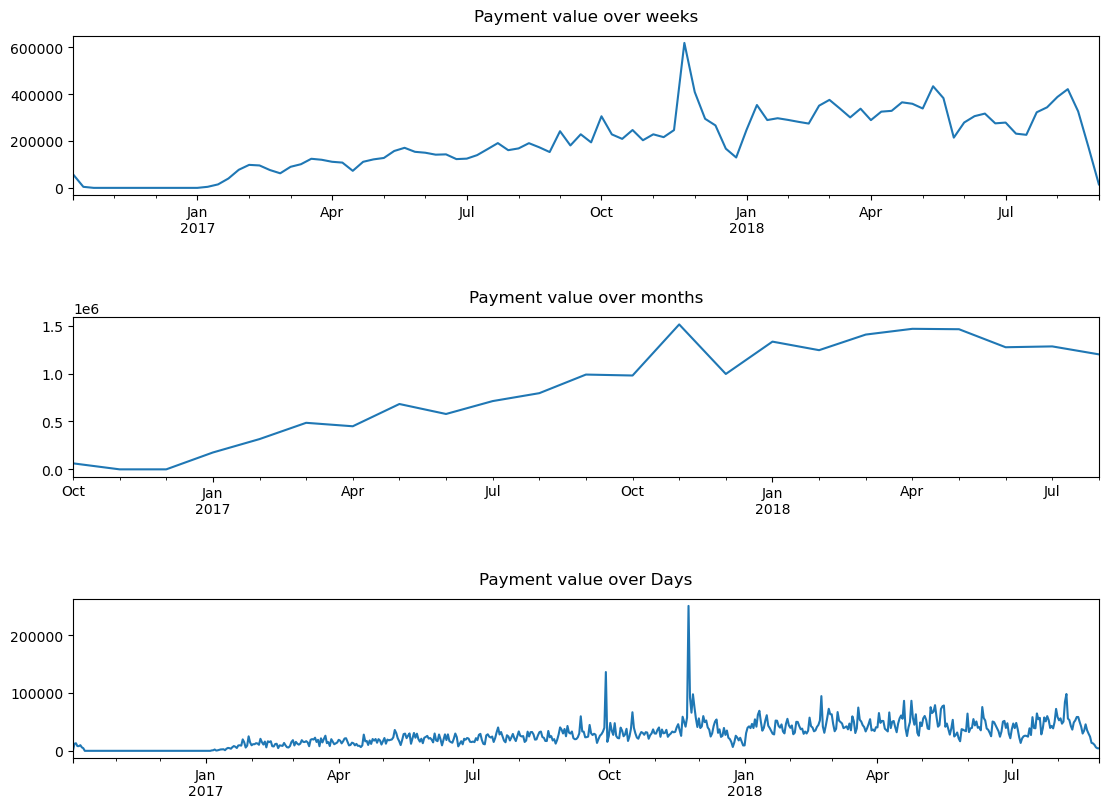

In [191]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d')
df.set_index('order_purchase_timestamp', inplace=True)

plt.figure(figsize = (12, 9))

#First plot
plt.subplot(3,1,1)
df["payment_value"].resample('W').sum().plot()
plt.title('Payment value over weeks', fontdict = {'fontsize': 12}, pad = 10.5)
plt.xlabel(None)

#Second plot
plt.subplot(3,1,2)
df['payment_value'].resample('M').sum().plot()
plt.title('Payment value over months', fontdict = {'fontsize': 12}, pad = 10.5)
plt.xlabel(None)

#three plot
plt.subplot(3,1,3)
df['payment_value'].resample('d').sum().plot()
plt.title('Payment value over Days', fontdict = {'fontsize': 12}, pad = 10.5)
plt.xlabel(None)
plt.tight_layout(pad = 4)

In [161]:
from collections import Counter

outre_cat=list((Counter(df.product_category.value_counts().index.to_list())-Counter(df.product_category.value_counts().index.to_list()[0:10])).elements())
outre_cat
df.replace(outre_cat,"other", inplace=True)
df.product_category.value_counts()

Home                   22393
Technology             13021
Health_Beauty          11351
Fashion_Accessories     8533
Toys_Games              7941
Sports_Leisure          7101
other                   6291
Construction_Tools      5003
Automotive              3722
Office_Supplies         3370
Baby                    2753
Name: product_category, dtype: int64

In [162]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (MinMaxScaler(),make_column_selector(dtype_include=np.number))
    )

In [163]:
df = transformer.fit_transform(df)
df=pd.DataFrame(df)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.001210,1.00,0.019164,0.029291,0.159712
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000161,0.75,0.002680,0.020235,0.164029
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000,0.000701,0.50,0.010120,0.042033,0.772662
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,0.000000,0.000000,0.000000,0.000311,0.75,0.003733,0.043034,0.461871
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.250000,0.000000,0.000000,0.000000,0.001714,1.00,0.026603,0.041227,0.414388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416667,0.013514,0.013514,0.013514,0.037741,1.00,0.116444,0.607084,0.643165
91475,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000686,0.75,0.009510,0.048062,0.376978
91476,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.000000,0.000000,0.000000,0.000941,1.00,0.013224,0.055067,0.817266
91477,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208333,0.000000,0.000000,0.000000,0.001135,1.00,0.016951,0.045621,0.171223


In [164]:
# Choose optimal K using Elbow method
inertia = []
for cluster in range(1, 10):
        kmeans = KMeans( n_clusters = cluster)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        print('Cluster initiation: {}'.format(cluster))



Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


Text(0, 0.5, 'Cout du modèle (inertia)')

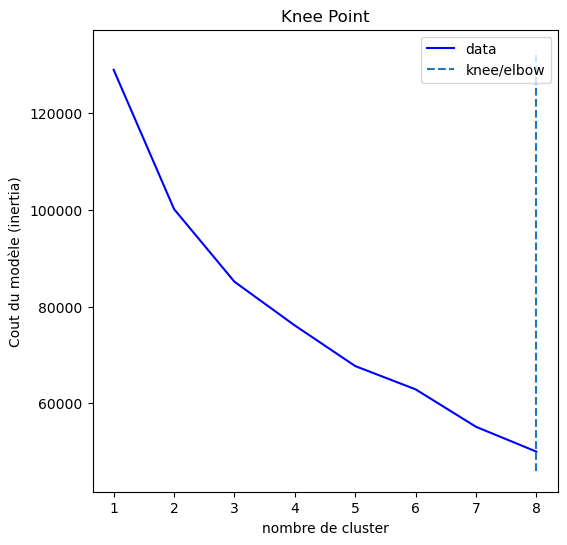

In [165]:
x,y = range(1,9),inertia[:-1]
kl = KneeLocator(x,y, curve='convex')
kl.plot_knee()
plt.xlabel('nombre de cluster')
plt.ylabel('Cout du modèle (inertia)')

In [166]:
df = pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','order_purchase_timestamp','customer_unique_id'], axis=1)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289
...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120


In [167]:
a = FunctionTransformer(func=np.log1p)
preprocessing = make_column_transformer((a,make_column_selector(dtype_include=np.number)),remainder='passthrough')
log=preprocessing.fit_transform(df)
log[0]

array([2.1972245773362196, 0.6931471805599453, 0.6931471805599453,
       0.6931471805599453, 4.9621450849358215, 1.791759469228055,
       4.874433672915854, 2.5649493574615367, 4.727387818712341,
       'credit_card', 'Home'], dtype=object)

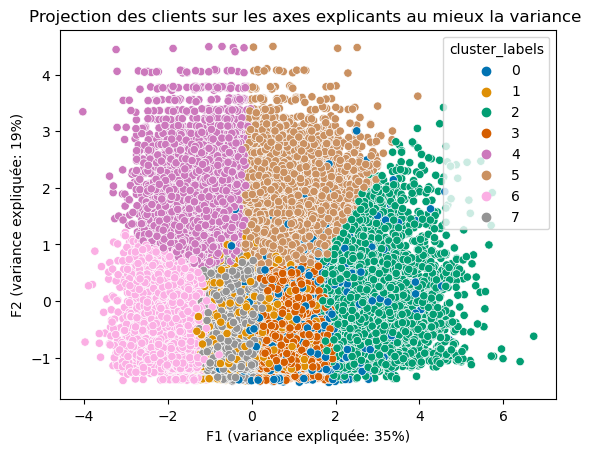

In [168]:
func_log = FunctionTransformer(func=np.log1p)
func_abs=FunctionTransformer(func=np.abs)

pipe_num= make_pipeline(func_abs,func_log)

transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=['float','int'])),
    (pipe_num,make_column_selector(dtype_include=['float','int']))
    )

pca=PCA(n_components=0.95)
pipe_pca= make_pipeline(transformer,pca)

df_acp=pd.DataFrame(pipe_pca.fit_transform(df))


clustering =KMeans(n_clusters=8).fit(df_acp)
df_acp['cluster_labels']=pd.Series(clustering.labels_)

sns.scatterplot(data=df_acp, x=0, y=1, hue='cluster_labels', palette='colorblind')
plt.title('Projection des clients sur les axes explicants au mieux la variance ')
plt.xlabel("F1 (variance expliquée: 35%)")
plt.ylabel("F2 (variance expliquée: 19%)")
plt.show()

In [169]:
print(pca.explained_variance_ratio_.round(2))

[0.35 0.19 0.09 0.06 0.05 0.04 0.03 0.03 0.02 0.02 0.02 0.02 0.01 0.01]


In [170]:
df['cluster_labels']=pd.Series(clustering.labels_)
df

,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency,cluster_labels
0,credit_card,Home,8,1,1,1,141.90,5.0,129.90,12.00,112,3
1,credit_card,Health_Beauty,1,1,1,1,27.19,4.0,18.90,8.29,115,6
2,credit_card,Office_Supplies,8,1,1,1,86.22,3.0,69.00,17.22,538,7
3,credit_card,Technology,4,1,1,1,43.62,4.0,25.99,17.63,322,6
4,credit_card,Technology,6,1,1,1,196.89,5.0,180.00,16.89,289,3
...,...,...,...,...,...,...,...,...,...,...,...,...
91474,credit_card,Health_Beauty,10,2,2,2,4134.84,5.0,785.00,248.71,448,2
91475,credit_card,Baby,1,1,1,1,84.58,4.0,64.89,19.69,263,7
91476,credit_card,Automotive,1,1,1,1,112.46,5.0,89.90,22.56,569,7
91477,credit_card,Fashion_Accessories,5,1,1,1,133.69,5.0,115.00,18.69,120,3


In [171]:
df_num=df[['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency']]

mms=MinMaxScaler(feature_range=(1,5))

num_cols= df.select_dtypes(include='number').columns
df_num['cluster_labels']=pd.Series(clustering.labels_)

list_agg = {}
for col in num_cols:
    list_agg[f'{col}'] = 'mean'

df_mean=df_num.groupby('cluster_labels').agg(list_agg).drop('cluster_labels',axis=1)


df_mms=pd.DataFrame(mms.fit_transform(df_mean),columns=['payment_installments','orders','products','sellers','payment_value','review_score','price','freight_value','recency'])
df_mms


/tmp/ipykernel_54326/115792397.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,3.107219,5.000000,5.000000,5.000000,4.474385,1.000000,1.409668,1.626919,4.556067
1,1.000000,1.165531,1.165531,1.165531,1.466291,3.993182,1.517416,1.767689,4.841832
2,5.000000,1.287727,1.287727,1.287727,5.000000,3.503449,5.000000,5.000000,4.309782
3,3.861493,1.000000,1.000000,1.000000,1.718003,3.960644,1.931784,2.202185,5.000000
4,1.509514,1.132063,1.132063,1.132063,1.123283,5.000000,1.129994,1.208034,1.000000
5,3.040844,1.228595,1.228595,1.228595,1.864757,4.922191,1.876652,2.702842,1.061063
6,1.361025,1.105271,1.105271,1.105271,1.000000,4.210758,1.000000,1.000000,4.834279
7,2.193529,1.114853,1.114853,1.114853,1.228573,4.138226,1.277594,1.294083,4.810150


In [172]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_mms.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=num_cols,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)

In [173]:
# func_log = FunctionTransformer(func=np.log1p)
# func_abs=FunctionTransformer(func=np.abs)

# pipe_num= make_pipeline(func_abs,func_log)

# transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=['float','int'])),
#     (pipe_num,make_column_selector(dtype_include=np.number)),remainder='passthrough')


# pipe_tsne = make_pipeline(transformer,TSNE()) 
# array_tsne=pipe_tsne.fit_transform(df)

# kprototype = KPrototypes(n_jobs = -1, n_clusters =4, init = 'Huang', random_state = 0)
# kprototype.fit_predict(array_tsne, categorical = [9,10])

# df_tsne=pd.DataFrame(array_tsne,columns=['f1','f2'])
# df_tsne['cluster_labels']=pd.Series(kprototype.labels_)

# plt.scatter(df_tsne.f1,df_tsne.f2,c=df_tsne.cluster_labels)
# plt.show()

In [174]:
dummy_product=pd.get_dummies(df.product_category,sparse=False)
prod_col=dummy_product.columns.to_list()

list_agg = {}
for col in prod_col:
    list_agg[f'{col}'] = 'sum'

dummy_product['cluster_labels']=pd.Series(clustering.labels_)

df_cat=dummy_product.groupby('cluster_labels').agg(list_agg)

cluster_count=dummy_product.cluster_labels.value_counts().sort_index().to_list()
for i in range(len(cluster_count)):
    df_cat.iloc[i]=(df_cat.iloc[i])/(cluster_count[i])


df_mms_cat=pd.DataFrame(mms.fit_transform(df_cat), columns=prod_col)
df_mms_cat


,Agro_Industry_Commerce,Arts_Music,Automotive,Baby,Books,Construction_Tools,Fashion_Accessories,Food_Beverage,Furniture,Gardening,Health_Beauty,Home,Market_place,Office_Supplies,Party_Supplies,Pet_Supplies,Signaling_Security,Sports_Leisure,Technology,Toys_Games
0,1.935086,1.000000,1.000000,1.000000,1.254345,5.000000,1.000000,2.426519,3.760707,3.857371,1.000000,5.000000,1.913965,3.323542,2.213430,2.185212,5.000000,3.174698,1.312064,1.000000
1,1.692547,2.284460,2.498768,3.206069,2.649180,3.697451,2.658289,2.028750,3.225938,1.556333,2.596305,2.326241,3.680303,3.973310,2.501734,2.463062,2.643784,5.000000,1.370734,3.552009
2,5.000000,5.000000,4.540467,5.000000,1.000000,4.138404,5.000000,1.000000,4.570175,3.805839,4.936018,1.000000,1.000000,2.344252,1.040554,1.331579,3.511383,1.000000,1.154920,4.080415
3,1.262724,1.621992,3.155937,3.762840,1.736784,2.233650,4.197041,1.380708,3.953549,1.000000,3.074552,1.907309,2.569620,5.000000,1.000000,2.357585,1.595990,4.472242,1.021056,5.000000
4,1.217157,2.524629,5.000000,4.963791,4.993576,2.547691,1.899541,5.000000,2.142282,4.852802,3.986574,2.314889,1.355550,1.822850,5.000000,3.464962,4.494529,3.312265,1.768510,1.581618
5,2.394853,2.112719,3.176780,4.096872,1.128354,3.883262,3.901867,2.100550,5.000000,2.230709,5.000000,2.517452,1.002478,3.187462,2.297656,5.000000,4.588291,1.556717,1.000000,1.869830
6,1.000000,1.537530,2.834250,1.268367,5.000000,1.000000,1.033351,3.191445,1.000000,5.000000,2.039830,1.015093,5.000000,1.000000,3.272490,1.000000,2.862581,1.972926,5.000000,2.312966
7,1.496184,1.709622,1.728150,3.828513,2.400683,3.150617,2.493560,2.527317,1.656217,2.016246,3.458936,3.094872,3.160590,2.752305,3.115967,2.925561,1.000000,4.470052,1.000806,3.530146


In [175]:
# Créer une figure en radar pour chaque cluster
fig = go.Figure()

for cluster, row in df_mms_cat.iterrows():
    values = row.values.tolist()
    

    

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=prod_col,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

# Mettre en forme la figurenum_cols,
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
    ),
    showlegend=True,
    width=780,
    height=780

)

# Afficher la figure
fig.show()
figsize = (60,60)

In [176]:
df= pd.read_csv('data.csv')
df.rename(columns={"order_item_id": "orders", "product_id": "products", "seller_id":'sellers'}, inplace=True)
df['payment_installments']=df['payment_installments'].astype('int64')
df= df.drop(['customer_city','customer_state','customer_zip_code_prefix','seller_city','seller_state','customer_unique_id.1','customer_unique_id'], axis=1)
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.strftime('%Y-%m')
df=df.sort_values('order_purchase_timestamp').reset_index()
df

,index,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,order_purchase_timestamp,recency
0,71848,credit_card,Office_Supplies,5,1,1,1,115.22,2.0,86.99,28.23,2016-10,695
1,50256,credit_card,Sports_Leisure,3,1,1,1,61.16,5.0,49.99,11.17,2016-10,691
2,14113,credit_card,Sports_Leisure,10,1,1,1,818.12,5.0,649.00,169.12,2016-10,694
3,11864,boleto,Health_Beauty,1,1,1,1,87.53,4.0,69.90,17.63,2016-10,692
4,91385,credit_card,Home,6,2,2,2,218.04,5.0,43.65,10.86,2016-10,690
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91474,83793,debit_card,Home,1,1,1,1,151.54,5.0,129.99,21.55,2018-08,28
91475,23285,credit_card,Technology,1,1,1,1,57.60,5.0,49.99,7.61,2018-08,17
91476,23293,credit_card,Technology,1,1,1,1,62.86,5.0,54.90,7.96,2018-08,22
91477,55011,credit_card,Fashion_Accessories,3,2,2,2,1089.04,4.0,252.40,19.86,2018-08,25


In [177]:

df_ari_t0=df[df['order_purchase_timestamp']<'2017-10']
df_ari_t0=df_ari_t0.drop('order_purchase_timestamp',axis=1)

df_ari_t1=df[df['order_purchase_timestamp']<'2018-01']
df_ari_t1=df_ari_t1.drop('order_purchase_timestamp',axis=1)

df_ari_t2=df[df['order_purchase_timestamp']<'2018-04']
df_ari_t2=df_ari_t2.drop('order_purchase_timestamp',axis=1)

df_ari_t3=df[df['order_purchase_timestamp']<'2018-07']
df_ari_t3=df_ari_t3.drop('order_purchase_timestamp',axis=1)

df_ari_t4=df[df['order_purchase_timestamp']<'2018-07']
df_ari_t4=df_ari_t4.drop('order_purchase_timestamp',axis=1)


In [178]:
df_ari_t2

,index,payment_type,product_category,payment_installments,orders,products,sellers,payment_value,review_score,price,freight_value,recency
0,71848,credit_card,Office_Supplies,5,1,1,1,115.22,2.0,86.99,28.230,695
1,50256,credit_card,Sports_Leisure,3,1,1,1,61.16,5.0,49.99,11.170,691
2,14113,credit_card,Sports_Leisure,10,1,1,1,818.12,5.0,649.00,169.120,694
3,11864,boleto,Health_Beauty,1,1,1,1,87.53,4.0,69.90,17.630,692
4,91385,credit_card,Home,6,2,2,2,218.04,5.0,43.65,10.860,690
...,...,...,...,...,...,...,...,...,...,...,...,...
60474,84068,credit_card,Toys_Games,2,1,1,1,47.43,5.0,35.00,12.430,166
60475,62820,boleto,Signaling_Security,1,1,1,1,88.36,1.0,69.99,18.370,177
60476,88993,credit_card,Home,12,2,2,2,912.32,1.0,209.90,18.180,152
60477,50801,credit_card,Toys_Games,2,1,1,1,51.69,5.0,34.90,16.790,179


In [179]:
index=df_ari_t0.index.to_list()

In [180]:
func_log = FunctionTransformer(func=np.log1p)
func_abs=FunctionTransformer(func=np.abs)

pipe_num= make_pipeline(func_abs,func_log)

transformer = make_column_transformer(
    (OneHotEncoder(sparse=False),make_column_selector(dtype_exclude=np.number)),
    (pipe_num,make_column_selector(dtype_include=np.number))
    )

pipe_pca= make_pipeline(transformer,PCA(n_components=0.95))

df_acp_t0=pd.DataFrame(pipe_pca.fit_transform(df_ari_t0))



clustering_t0 =KMeans(n_clusters=8).fit(df_acp_t0)
df_acp_t0['cluster_labels_t0']=pd.Series(clustering_t0.labels_)
df_ari_t0['cluster_labels_t0']=pd.Series(clustering_t0.labels_)


In [181]:


df_acp_t1=pd.DataFrame(pipe_pca.fit_transform(df_ari_t1))



clustering_t1 =KMeans(n_clusters=8).fit(df_acp_t1)
df_acp_t1['cluster_labels_t1']=pd.Series(clustering_t1.labels_)
df_ari_t1['cluster_labels_t1']=pd.Series(clustering_t1.labels_)



In [182]:
df_acp_t2=pd.DataFrame(pipe_pca.fit_transform(df_ari_t2))



clustering_t2 =KMeans(n_clusters=8).fit(df_acp_t2)
df_acp_t2['cluster_labels_t2']=pd.Series(clustering_t2.labels_)
df_ari_t2['cluster_labels_t2']=pd.Series(clustering_t2.labels_)


In [183]:
df_acp_t3=pd.DataFrame(pipe_pca.fit_transform(df_ari_t3))



clustering_t3 =KMeans(n_clusters=8).fit(df_acp_t3)
df_acp_t3['cluster_labels_t3']=pd.Series(clustering_t3.labels_)
df_ari_t3['cluster_labels_t3']=pd.Series(clustering_t3.labels_)



In [184]:
df_acp_t4=pd.DataFrame(pipe_pca.fit_transform(df_ari_t4))



clustering_t4 =KMeans(n_clusters=8).fit(df_acp_t4)
df_acp_t4['cluster_labels_t4']=pd.Series(clustering_t4.labels_)
df_ari_t4['cluster_labels_t4']=pd.Series(clustering_t4.labels_)

In [185]:
cluster_t0=df_ari_t0['cluster_labels_t0'].loc[index].to_list()
cluster_t1=df_ari_t1['cluster_labels_t1'].loc[index].to_list()
cluster_t2=df_ari_t2['cluster_labels_t2'].loc[index].to_list()
cluster_t3=df_ari_t3['cluster_labels_t3'].loc[index].to_list()
cluster_t4=df_ari_t4['cluster_labels_t4'].loc[index].to_list()



In [186]:
adjusted_rand_score(cluster_t0,cluster_t1)
adjusted_rand_score(cluster_t0,cluster_t2)
adjusted_rand_score(cluster_t0,cluster_t3)
adjusted_rand_score(cluster_t0,cluster_t4)

0.9408080373390357

In [187]:
df_ari= pd.DataFrame({'+3 mois':adjusted_rand_score(cluster_t0,cluster_t1),'+6 mois':adjusted_rand_score(cluster_t0,cluster_t2),'+9 mois':adjusted_rand_score(cluster_t0,cluster_t3),'+12 mois':adjusted_rand_score(cluster_t0,cluster_t4)}, index=['score ari'])

In [188]:
df_ari

,+3 mois,+6 mois,+9 mois,+12 mois
score ari,0.759495,0.918258,0.938936,0.940808


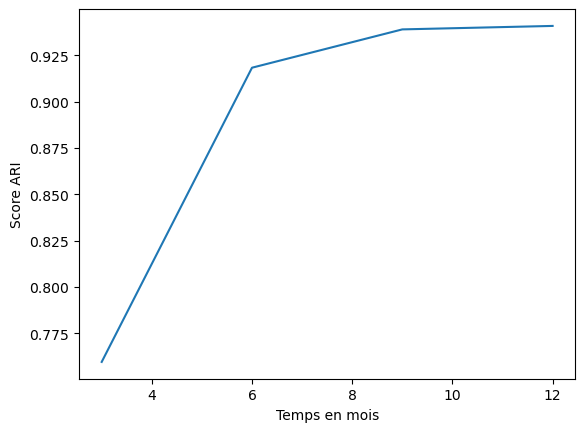

In [189]:
plt.plot([3,6,9,12],[adjusted_rand_score(cluster_t0,cluster_t1),adjusted_rand_score(cluster_t0,cluster_t2),adjusted_rand_score(cluster_t0,cluster_t3),adjusted_rand_score(cluster_t0,cluster_t4)])


plt.xlabel("Temps en mois")
plt.ylabel("Score ARI")

plt.show()